<a href="https://colab.research.google.com/github/HarshESC/Unsupervised-Learning-Capstone-NJ_Transit_-_Amtrak/blob/main/Amtrak_NJ_Transit_Unsupervised_Learning_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### INTRODUCTION:
NJ Transit is the second largest commuter rail network in the United States by ridership; it spans New Jersey and connects the state to New York City. On the Northeast Corridor, the busiest passenger rail line in the United States, Amtrak also operates passenger rail service; together, NJ Transit and Amtrak operate nearly 750 trains across the NJ Transit rail network.

With serving over 300,000 riders on the average weekday, there tends to be a lot of delay.  Wouldn't it be nice if we could predict when delays happen and plan schedule our transits more efficiently.  

In this analysis, we will be exploring the train delay using clustering techniques in order to predict when delays occur.  

This would allow for robust prediction.  This data could be used to derive a system-level prediction system for the NJ Transit network. Such a system could provide intelligent, targeted advance warnings of delays or cancellations for millions of riders.

### RESEARCH QUESTION:
Which dimension reduction technique, along with the appropriate clustering techniques would can most accurately predict the delays of trains?

### DATA:

This dataset can be found on [Kaggle](https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance), provided by the user Pranav Badami.

This dataset contains monthly CSVs covering the performance of nearly every train trip on the NJ Transit rail network from March 2018 to May 2020.  I will be covering the most recent data, May 2020 to predict as accurately as possible the current amount of delay.


### METHODS

1. Perform data exploration and create a dataset for rush hour and a dataset for Friday Delays.
2.  Using PCA and K-means to do the clustering (visualizations and many clusters, justify using silhouette scores)
3. For PCA/K-means (K>= 4), draw the bar graphs to answer the following questions:
    a. Which cluster contains the most train delay on Friday?
    b. Which cluster contains the most train delays for the rush hour in the weekday?
4. Using T-sne and GMM to do the clustering (visualizations and many clusters, justify using silhouette scores)
5. For T-sne/GMM (K>= 4), draw the bar graphs to answer the following questions:
    a. Which cluster contains the most train delay on Friday?
    b. Which cluster contains the most train delays for the rush hour in the weekday?
6. Write up the comparisons analysis and conclusions.


### Let's Look at our Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

import warnings
warnings.filterwarnings('ignore')



from google.colab import drive 
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/"
%cd "/content/gdrive/My Drive/Capstone 3"

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter, defaultdict
from sklearn import metrics


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Capstone 3


In [2]:
df = pd.read_csv('train.csv')
df.head()

,dateID,date,DayOfWeekID,DayOfWeek,isnumber,train_id,stop_sequence,from_id,from,to_id,to,rush_hour,scheduled_time,actual_time,is_Delayed_id,is_Delayed,delay_minutes,statusID,status,lineID,line,typeID,type
0,1,5/1/2020,6,Friday,True,5543,1.0,107,Newark Penn Station,107,Newark Penn Station,0,23:38,23:40,1,yes,2.150000,1,departed,1,Raritan Valley,1,NJ Transit
1,1,5/1/2020,6,Friday,True,5543,2.0,107,Newark Penn Station,38105,Union,0,23:47,23:47,1,yes,0.016667,1,departed,1,Raritan Valley,1,NJ Transit
2,1,5/1/2020,6,Friday,True,5543,3.0,38105,Union,31,Roselle Park,0,23:50,23:51,1,yes,1.066667,1,departed,1,Raritan Valley,1,NJ Transit
3,1,5/1/2020,6,Friday,True,5543,4.0,31,Roselle Park,32,Cranford,0,23:55,23:55,1,yes,0.516667,1,departed,1,Raritan Valley,1,NJ Transit
4,1,5/1/2020,6,Friday,True,5543,5.0,32,Cranford,155,Westfield,0,23:59,23:59,1,yes,0.016667,1,departed,1,Raritan Valley,1,NJ Transit


In [3]:
# Check for nulls
df.isnull().sum()*100/df.isnull().count()


dateID             0.000000
date               0.000000
DayOfWeekID        0.000000
DayOfWeek          0.000000
isnumber           0.000000
train_id           0.000000
stop_sequence     11.678048
from_id            0.000000
from               0.000000
to_id              0.000000
to                 0.000000
rush_hour          0.000000
scheduled_time    11.678048
actual_time        0.000000
is_Delayed_id      0.000000
is_Delayed         0.000000
delay_minutes     11.678048
statusID           0.000000
status             0.000000
lineID             0.000000
line               0.000000
typeID             0.000000
type               0.000000
dtype: float64

Seems to be quite a bit of nulls.  We will drop them from this dataset in order to use only data that is reported.  

In [4]:
#Drop nulls and see how many observations we have:
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 87172 entries, 0 to 98697
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dateID          87172 non-null  int64  
 1   date            87172 non-null  object 
 2   DayOfWeekID     87172 non-null  int64  
 3   DayOfWeek       87172 non-null  object 
 4   isnumber        87172 non-null  bool   
 5   train_id        87172 non-null  object 
 6   stop_sequence   87172 non-null  float64
 7   from_id         87172 non-null  int64  
 8   from            87172 non-null  object 
 9   to_id           87172 non-null  int64  
 10  to              87172 non-null  object 
 11  rush_hour       87172 non-null  int64  
 12  scheduled_time  87172 non-null  object 
 13  actual_time     87172 non-null  object 
 14  is_Delayed_id   87172 non-null  int64  
 15  is_Delayed      87172 non-null  object 
 16  delay_minutes   87172 non-null  float64
 17  statusID        87172 non-null 

Lets check out some of our variables we will be analyzing where train delays occur.

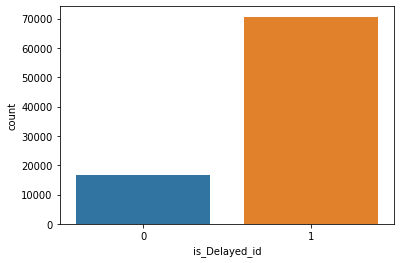

In [5]:
import seaborn as sns
sns.countplot(df['is_Delayed_id'])


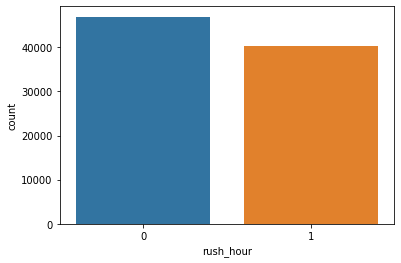

In [6]:
sns.countplot(df['rush_hour'])


Friday       15511
Monday       15334
Sunday       12997
Saturday     12827
Wednesday    10319
Tuesday      10130
Thursday     10054
Name: DayOfWeek, dtype: int64

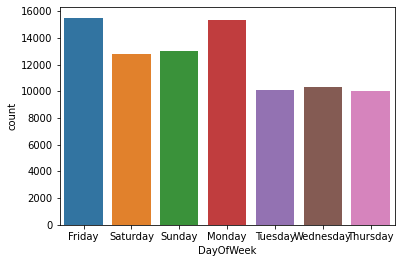

In [7]:
sns.countplot(df['DayOfWeek'])
df['DayOfWeek'].value_counts()

Friday has the most data count, so we will use Friday as one of our observations.  

departed     76862
estimated     7824
cancelled     2486
Name: status, dtype: int64

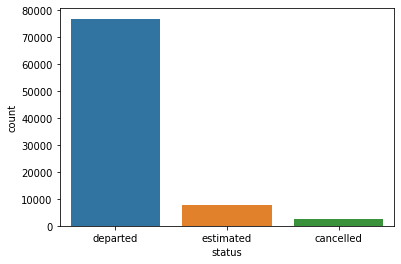

In [8]:
sns.countplot(df['status'])
df['status'].value_counts()

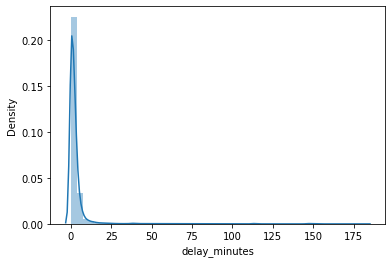

In [9]:
sns.distplot(df['delay_minutes'])

A distribution of on average, how long of a delay the trains are.  Based on this, seems to be around 10 minutes on average

In [10]:
df.nunique()

dateID              18
date                18
DayOfWeekID          7
DayOfWeek            7
isnumber             1
train_id           464
stop_sequence       26
from_id            156
from               156
to_id              155
to                 155
rush_hour            2
scheduled_time    1295
actual_time       1368
is_Delayed_id        2
is_Delayed           2
delay_minutes     1754
statusID             3
status               3
lineID              20
line                11
typeID               1
type                 1
dtype: int64

In [11]:
# Descriptive statistics.
df.describe()

,dateID,DayOfWeekID,stop_sequence,from_id,to_id,rush_hour,is_Delayed_id,delay_minutes,statusID,typeID
count,87172.000000,87172.000000,87172.000000,87172.000000,87172.000000,87172.000000,87172.000000,87172.000000,87172.000000,87172.0
mean,9.462889,3.997339,8.046907,4303.809537,4346.908595,0.462064,0.810054,3.281289,1.061235,1.0
std,5.160223,2.076806,4.984259,11927.826579,11980.281298,0.498562,0.392261,10.253101,0.338413,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,5.000000,2.000000,4.000000,48.000000,50.000000,0.000000,1.000000,0.116667,1.000000,1.0
50%,9.000000,4.000000,8.000000,99.000000,102.000000,0.000000,1.000000,1.200000,1.000000,1.0
75%,14.000000,6.000000,11.000000,131.000000,134.000000,1.000000,1.000000,3.083333,1.000000,1.0
max,18.000000,7.000000,26.000000,43599.000000,43599.000000,1.000000,1.000000,182.000000,2.000000,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f17c7e0a610>,
      dtype=object)

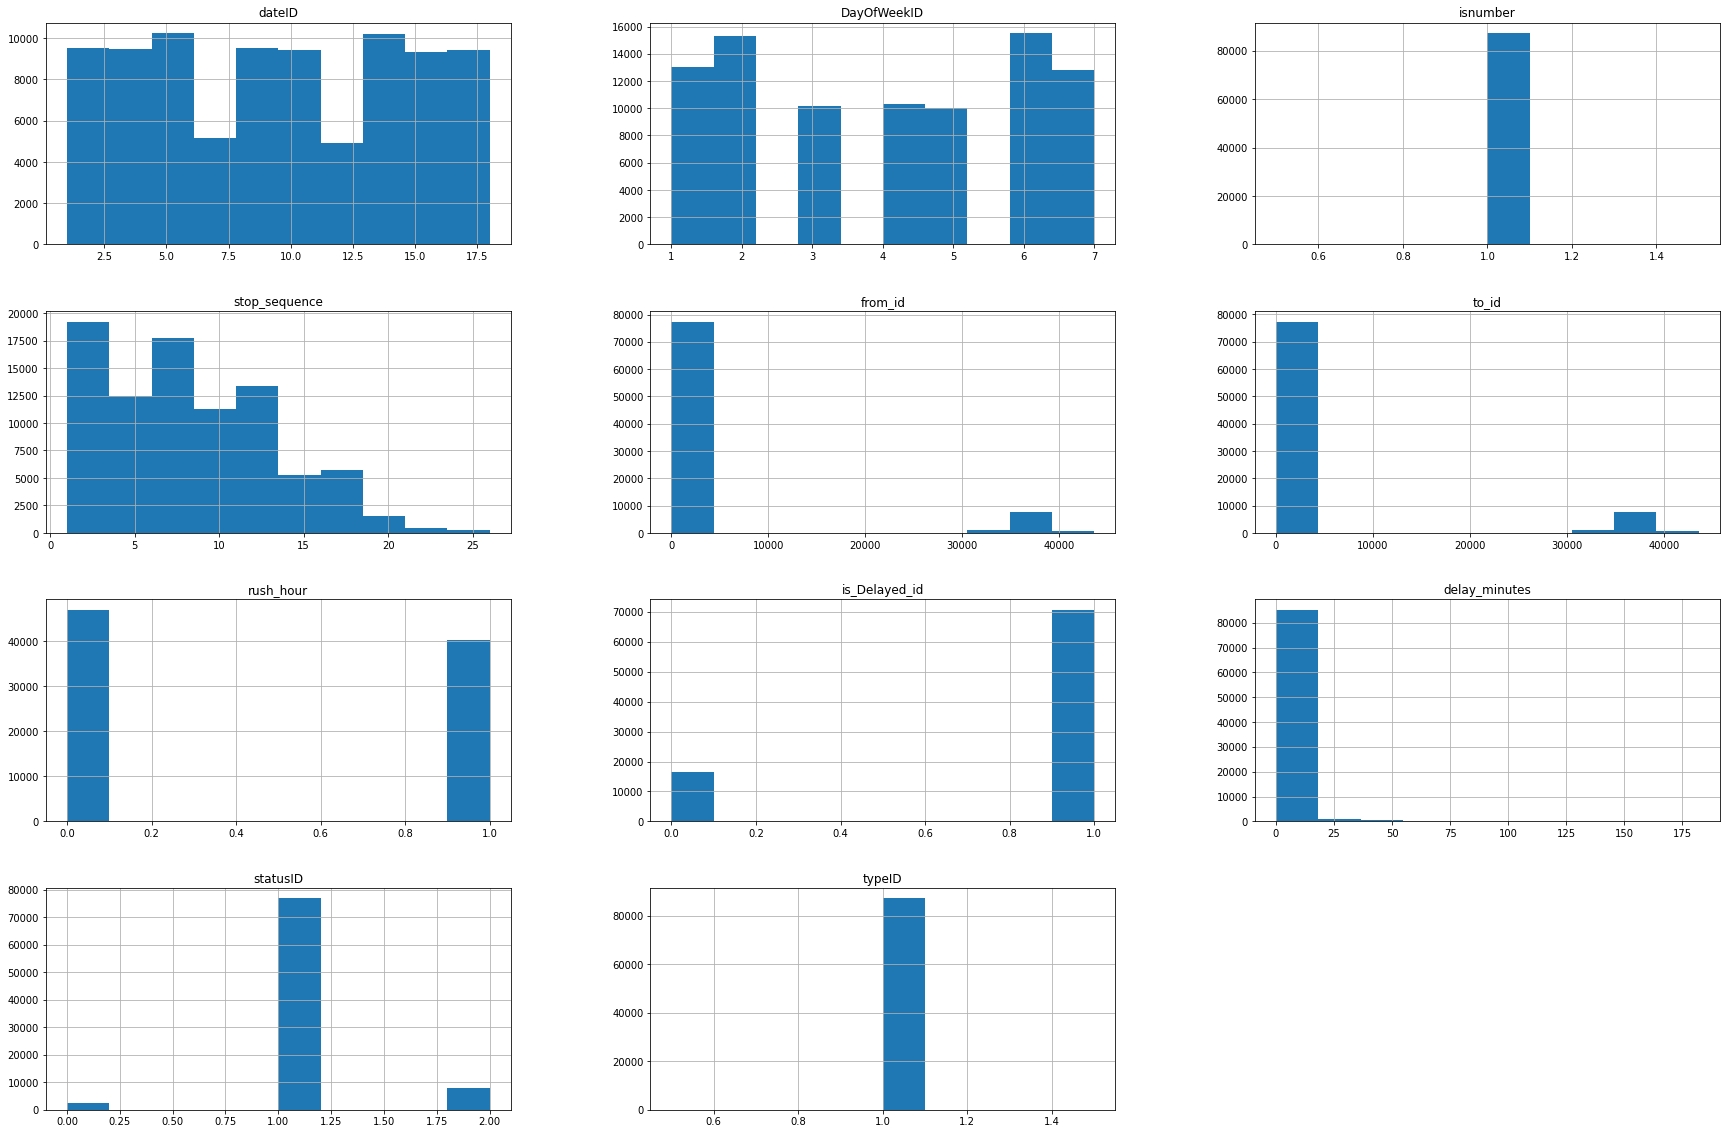

In [12]:
df.hist(figsize=(30,20))


A lot of irregular distributions, mainly due to a lot of our targets being binary or categorical values.

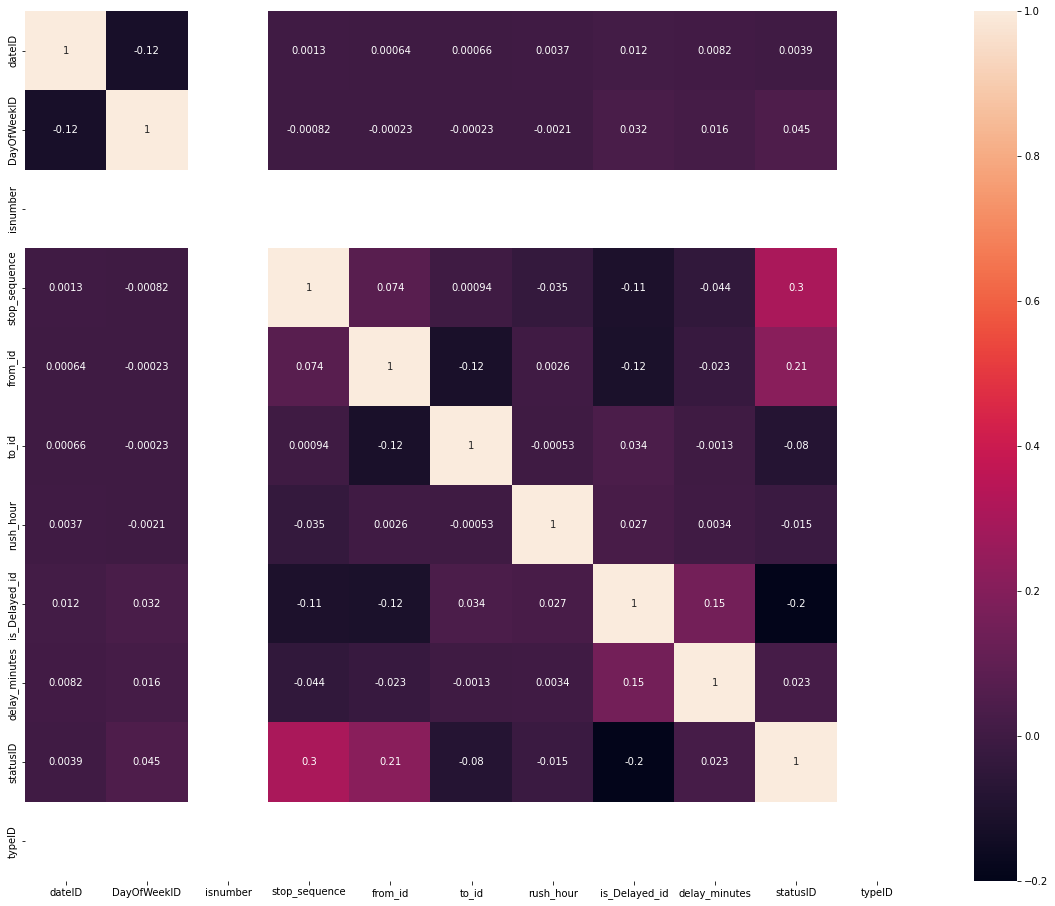


Correlation Table


,dateID,DayOfWeekID,isnumber,stop_sequence,from_id,to_id,rush_hour,is_Delayed_id,delay_minutes,statusID,typeID
dateID,1.000000,-0.121237,NaN,0.001307,0.000637,0.000656,0.003658,0.011899,0.008166,0.003863,NaN
DayOfWeekID,-0.121237,1.000000,NaN,-0.000821,-0.000233,-0.000231,-0.002059,0.032176,0.015804,0.045102,NaN
isnumber,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stop_sequence,0.001307,-0.000821,NaN,1.000000,0.073565,0.000941,-0.034930,-0.107307,-0.044079,0.303198,NaN
from_id,0.000637,-0.000233,NaN,0.073565,1.000000,-0.116791,0.002570,-0.116064,-0.022739,0.212960,NaN
to_id,0.000656,-0.000231,NaN,0.000941,-0.116791,1.000000,-0.000526,0.034410,-0.001278,-0.080324,NaN
rush_hour,0.003658,-0.002059,NaN,-0.034930,0.002570,-0.000526,1.000000,0.026798,0.003393,-0.015468,NaN
is_Delayed_id,0.011899,0.032176,NaN,-0.107307,-0.116064,0.034410,0.026798,1.000000,0.154971,-0.200496,NaN
delay_minutes,0.008166,0.015804,NaN,-0.044079,-0.022739,-0.001278,0.003393,0.154971,1.000000,0.022773,NaN
statusID,0.003863,0.045102,NaN,0.303198,0.212960,-0.080324,-0.015468,-0.200496,0.022773,1.000000,NaN


In [13]:
# Visualize correlation between independant variables and the target variable. Here, the target variable is 'Chance_of_Admit'
plt.figure(figsize=(20,16))
sns.heatmap(df.corr(),annot = True)
plt.show()

print()
print("Correlation Table")
# Correlation factors for 'delay time'.
df.corr()

Let's perform one hot encoding on statusID and DayofTheWeek ID due to them being categorical variables and also being one of the useful features for our dataset.  

In [14]:
df


,dateID,date,DayOfWeekID,DayOfWeek,isnumber,train_id,stop_sequence,from_id,from,to_id,to,rush_hour,scheduled_time,actual_time,is_Delayed_id,is_Delayed,delay_minutes,statusID,status,lineID,line,typeID,type
0,1,5/1/2020,6,Friday,True,5543,1.0,107,Newark Penn Station,107,Newark Penn Station,0,23:38,23:40,1,yes,2.150000,1,departed,1,Raritan Valley,1,NJ Transit
1,1,5/1/2020,6,Friday,True,5543,2.0,107,Newark Penn Station,38105,Union,0,23:47,23:47,1,yes,0.016667,1,departed,1,Raritan Valley,1,NJ Transit
2,1,5/1/2020,6,Friday,True,5543,3.0,38105,Union,31,Roselle Park,0,23:50,23:51,1,yes,1.066667,1,departed,1,Raritan Valley,1,NJ Transit
3,1,5/1/2020,6,Friday,True,5543,4.0,31,Roselle Park,32,Cranford,0,23:55,23:55,1,yes,0.516667,1,departed,1,Raritan Valley,1,NJ Transit
4,1,5/1/2020,6,Friday,True,5543,5.0,32,Cranford,155,Westfield,0,23:59,23:59,1,yes,0.016667,1,departed,1,Raritan Valley,1,NJ Transit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98693,18,5/18/2020,2,Monday,True,5529,9.0,120,Plainfield,36,Dunellen,1,17:16,17:19,1,yes,3.166667,1,departed,1,Raritan Valley,1,NJ Transit
98694,18,5/18/2020,2,Monday,True,5529,10.0,36,Dunellen,21,Bound Brook,1,17:21,17:24,1,yes,3.100000,1,departed,1,Raritan Valley,1,NJ Transit
98695,18,5/18/2020,2,Monday,True,5529,11.0,21,Bound Brook,24,Bridgewater,1,17:24,17:27,1,yes,3.183333,1,departed,1,Raritan Valley,1,NJ Transit
98696,18,5/18/2020,2,Monday,True,5529,12.0,24,Bridgewater,138,Somerville,1,17:30,17:33,1,yes,3.116667,1,departed,1,Raritan Valley,1,NJ Transit


In [15]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['statusID', 'DayOfWeekID'])
one_hot_encoded_data

,dateID,date,DayOfWeek,isnumber,train_id,stop_sequence,from_id,from,to_id,to,rush_hour,scheduled_time,actual_time,is_Delayed_id,is_Delayed,delay_minutes,status,lineID,line,typeID,type,statusID_0,statusID_1,statusID_2,DayOfWeekID_1,DayOfWeekID_2,DayOfWeekID_3,DayOfWeekID_4,DayOfWeekID_5,DayOfWeekID_6,DayOfWeekID_7
0,1,5/1/2020,Friday,True,5543,1.0,107,Newark Penn Station,107,Newark Penn Station,0,23:38,23:40,1,yes,2.150000,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,0,0,0,0,1,0
1,1,5/1/2020,Friday,True,5543,2.0,107,Newark Penn Station,38105,Union,0,23:47,23:47,1,yes,0.016667,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,0,0,0,0,1,0
2,1,5/1/2020,Friday,True,5543,3.0,38105,Union,31,Roselle Park,0,23:50,23:51,1,yes,1.066667,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,0,0,0,0,1,0
3,1,5/1/2020,Friday,True,5543,4.0,31,Roselle Park,32,Cranford,0,23:55,23:55,1,yes,0.516667,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,0,0,0,0,1,0
4,1,5/1/2020,Friday,True,5543,5.0,32,Cranford,155,Westfield,0,23:59,23:59,1,yes,0.016667,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98693,18,5/18/2020,Monday,True,5529,9.0,120,Plainfield,36,Dunellen,1,17:16,17:19,1,yes,3.166667,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,1,0,0,0,0,0
98694,18,5/18/2020,Monday,True,5529,10.0,36,Dunellen,21,Bound Brook,1,17:21,17:24,1,yes,3.100000,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,1,0,0,0,0,0
98695,18,5/18/2020,Monday,True,5529,11.0,21,Bound Brook,24,Bridgewater,1,17:24,17:27,1,yes,3.183333,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,1,0,0,0,0,0
98696,18,5/18/2020,Monday,True,5529,12.0,24,Bridgewater,138,Somerville,1,17:30,17:33,1,yes,3.116667,departed,1,Raritan Valley,1,NJ Transit,0,1,0,0,1,0,0,0,0,0


We will be using the following columns to predict train delay in our dataset.  

stop_sequence	rush_hour	is_Delayed_id	delay_minutes	statusID_0	statusID_1	statusID_2	DayOfWeekID_1	DayOfWeekID_2	DayOfWeekID_3	DayOfWeekID_4	DayOfWeekID_5	DayOfWeekID_6	DayOfWeekID_7

In [16]:
one_hot_encoded_data = one_hot_encoded_data.drop(['date', 'dateID', 'DayOfWeek', 'isnumber', 'train_id', 'from', 'to', 'is_Delayed', 'status', 'line', 'lineID', 'type', 'typeID', 'scheduled_time', 'actual_time'],axis=1)
one_hot_encoded_data = one_hot_encoded_data.drop(['from_id', 'to_id'], axis=1)
one_hot_encoded_data

,stop_sequence,rush_hour,is_Delayed_id,delay_minutes,statusID_0,statusID_1,statusID_2,DayOfWeekID_1,DayOfWeekID_2,DayOfWeekID_3,DayOfWeekID_4,DayOfWeekID_5,DayOfWeekID_6,DayOfWeekID_7
0,1.0,0,1,2.150000,0,1,0,0,0,0,0,0,1,0
1,2.0,0,1,0.016667,0,1,0,0,0,0,0,0,1,0
2,3.0,0,1,1.066667,0,1,0,0,0,0,0,0,1,0
3,4.0,0,1,0.516667,0,1,0,0,0,0,0,0,1,0
4,5.0,0,1,0.016667,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98693,9.0,1,1,3.166667,0,1,0,0,1,0,0,0,0,0
98694,10.0,1,1,3.100000,0,1,0,0,1,0,0,0,0,0
98695,11.0,1,1,3.183333,0,1,0,0,1,0,0,0,0,0
98696,12.0,1,1,3.116667,0,1,0,0,1,0,0,0,0,0


Our first question is to compared PCA Reduction with K Means Clustering.  So we will apply PCA and the cluster with K Means.

### PCA Reduction

In [17]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
Scaler.fit(one_hot_encoded_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
scaledData = Scaler.transform(one_hot_encoded_data)

In [19]:
scaledData

array([[-1.41384053, -0.92679852,  0.48423763, ..., -0.36107013,
         2.14942123, -0.41537147],
       [-1.21320776, -0.92679852,  0.48423763, ..., -0.36107013,
         2.14942123, -0.41537147],
       [-1.01257499, -0.92679852,  0.48423763, ..., -0.36107013,
         2.14942123, -0.41537147],
       ...,
       [ 0.59248718,  1.07898317,  0.48423763, ..., -0.36107013,
        -0.46524152, -0.41537147],
       [ 0.79311995,  1.07898317,  0.48423763, ..., -0.36107013,
        -0.46524152, -0.41537147],
       [ 0.99375272,  1.07898317, -2.06510181, ..., -0.36107013,
        -0.46524152, -0.41537147]])

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

In [21]:
pca_xnew = pca.fit(scaledData)

In [22]:
x_pca = pca.transform(scaledData)

In [23]:
scaledData.shape

(87172, 14)

In [24]:
x_pca.shape

(87172, 2)

In [25]:
scaledData

array([[-1.41384053, -0.92679852,  0.48423763, ..., -0.36107013,
         2.14942123, -0.41537147],
       [-1.21320776, -0.92679852,  0.48423763, ..., -0.36107013,
         2.14942123, -0.41537147],
       [-1.01257499, -0.92679852,  0.48423763, ..., -0.36107013,
         2.14942123, -0.41537147],
       ...,
       [ 0.59248718,  1.07898317,  0.48423763, ..., -0.36107013,
        -0.46524152, -0.41537147],
       [ 0.79311995,  1.07898317,  0.48423763, ..., -0.36107013,
        -0.46524152, -0.41537147],
       [ 0.99375272,  1.07898317, -2.06510181, ..., -0.36107013,
        -0.46524152, -0.41537147]])

In [26]:
x_pca

array([[-1.04513304,  0.16260719],
       [-0.97684998,  0.11887423],
       [-0.93252916,  0.03446327],
       ...,
       [-0.62542217, -0.76304955],
       [-0.57269575, -0.83319126],
       [ 4.30502824, -1.96132858]])

In [27]:
Data = one_hot_encoded_data.drop(['delay_minutes'], axis = 1)


In [28]:
# load data into X variables
X = Data

In [29]:
# need to standardize the features
X_std = StandardScaler().fit_transform(X)


### PCA K Means

Stripping PCA down to 2 components, and using clusters from 3 to 7 to compare.  We will be using silhouette scores to justify our solutions.

For any clusters >= 4, we will answer two questions with bar graphs:

    a. Which cluster contains the most train delay on Friday?
    b. Which cluster contains the most train delays for the rush hour in the weekday?


In [30]:
#Adjusting the PCA model to have 2 components:
pca = PCA(n_components=2)
pcadf_pca = pca.fit_transform(X_std)

In [31]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=3, random_state=42, max_iter=5000)

# Fit model
%timeit kmeans_cluster.fit(pcadf_pca)
km_y_pred3 = kmeans_cluster.predict(pcadf_pca)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, km_y_pred3, metric='euclidean')))


1 loop, best of 5: 495 ms per loop

The silhouette score of the k-Means solution: 0.7885047949506553


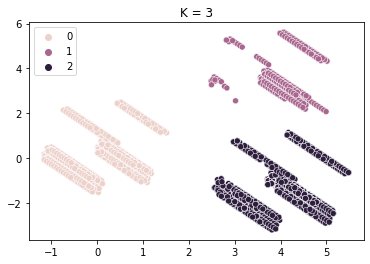

In [32]:
# Plot the solution.
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = km_y_pred3)
plt.title("K = 3")
plt.legend()
plt.show()

K = 3 seems fairly even.  It's pretty good with a score of 0.78.  But it's doesn't really answer our question too clearly, so we will check out the other ones.  

### K = 4

In [33]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=4, random_state=42, max_iter=5000)

# Fit model
%timeit kmeans_cluster.fit(pcadf_pca)
km_y_pred4 = kmeans_cluster.predict(pcadf_pca)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, km_y_pred4, metric='euclidean')))


1 loop, best of 5: 685 ms per loop

The silhouette score of the k-Means solution: 0.675876388050062


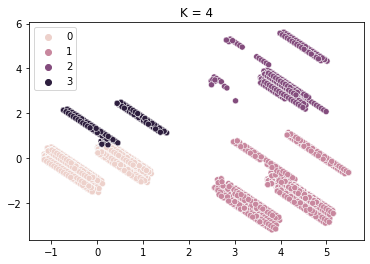

In [34]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = km_y_pred4)
plt.title("K = 4")
plt.legend()
plt.show()

In [35]:
one_hot_encoded_data['Cluster'] = pd.Series(km_y_pred4, index=one_hot_encoded_data.index)


In [36]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]


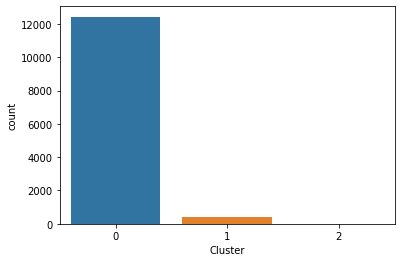

In [37]:
sns.countplot(friTrain['Cluster'])


In [38]:
friTrain['Cluster'].value_counts()

0    12431
1      398
2        2
Name: Cluster, dtype: int64

In [39]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]


In [40]:
rushweek['Cluster'].value_counts()

0    28309
3     3966
1      803
2        7
Name: Cluster, dtype: int64

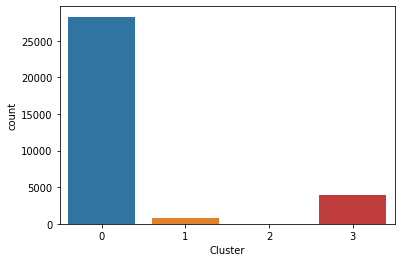

In [41]:
sns.countplot(rushweek['Cluster'])


### K = 5

In [42]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=5, random_state=42, max_iter=5000)

# Fit model
%timeit kmeans_cluster.fit(pcadf_pca)
km_y_pred5 = kmeans_cluster.predict(pcadf_pca)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, km_y_pred5, metric='euclidean')))


1 loop, best of 5: 802 ms per loop

The silhouette score of the k-Means solution: 0.5042131882357926


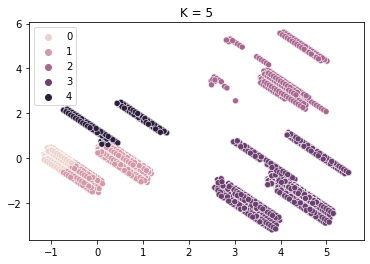

In [43]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = km_y_pred5)
plt.title("K = 5")
plt.legend()
plt.show()

In [44]:
one_hot_encoded_data['Cluster'] = pd.Series(km_y_pred5, index=one_hot_encoded_data.index)


In [45]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]



In [46]:
friTrain['Cluster'].value_counts()

0    8376
1    4055
3     398
2       2
Name: Cluster, dtype: int64

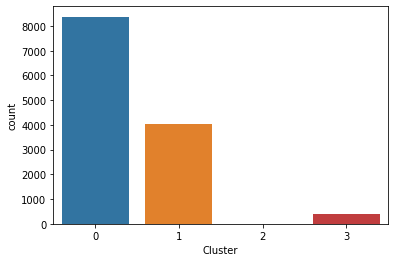

In [47]:
sns.countplot(friTrain['Cluster'])


In [48]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]



In [49]:
rushweek['Cluster'].value_counts()

0    20016
1     8293
4     3966
3      803
2        7
Name: Cluster, dtype: int64

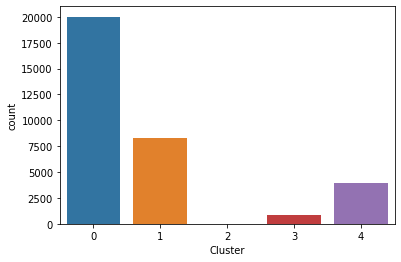

In [50]:
sns.countplot(rushweek['Cluster'])


### K = 6

In [51]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=6, random_state=42, max_iter=5000)

# Fit model
%timeit kmeans_cluster.fit(pcadf_pca)
km_y_pred6 = kmeans_cluster.predict(pcadf_pca)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, km_y_pred6, metric='euclidean')))


1 loop, best of 5: 1.05 s per loop

The silhouette score of the k-Means solution: 0.5494179299568109


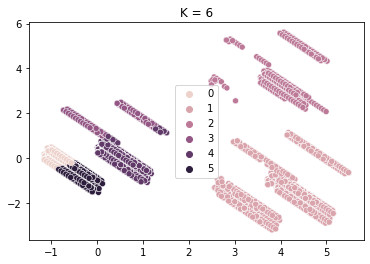

In [52]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = km_y_pred6)
plt.title("K = 6")
plt.legend()
plt.show()

In [53]:
one_hot_encoded_data['Cluster'] = pd.Series(km_y_pred6, index=one_hot_encoded_data.index)


In [54]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]


In [55]:
friTrain['Cluster'].value_counts()

0    6594
5    5837
1     398
2       2
Name: Cluster, dtype: int64

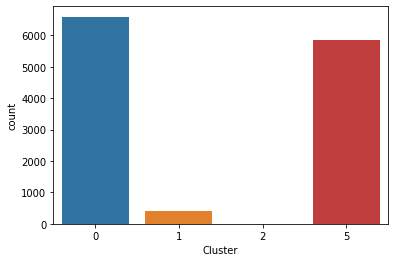

In [56]:
sns.countplot(friTrain['Cluster'])


In [57]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]


In [58]:
rushweek['Cluster'].value_counts()

0    16649
5    11660
3     3916
1      803
4       50
2        7
Name: Cluster, dtype: int64

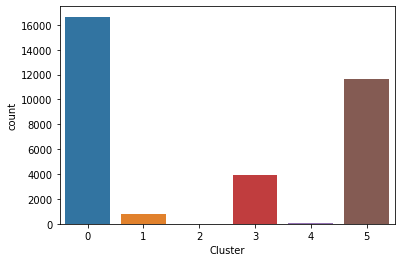

In [59]:
sns.countplot(rushweek['Cluster'])


### K = 7

In [60]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=7, random_state=42, max_iter=5000)

# Fit model
%timeit kmeans_cluster.fit(pcadf_pca)
km_y_pred7 = kmeans_cluster.predict(pcadf_pca)
print()
print("The silhouette score of the k-Means solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, km_y_pred7, metric='euclidean')))


1 loop, best of 5: 1.06 s per loop

The silhouette score of the k-Means solution: 0.5382261955289639


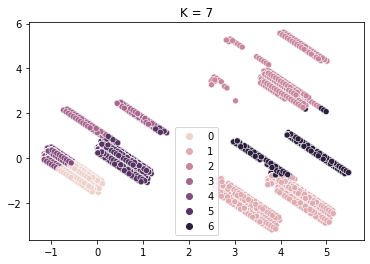

In [61]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = km_y_pred7)
plt.title("K = 7")
plt.legend()
plt.show()

In [62]:
one_hot_encoded_data['Cluster'] = pd.Series(km_y_pred7, index=one_hot_encoded_data.index)


In [63]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]



In [64]:
friTrain['Cluster'].value_counts()

4    6594
0    5837
1     398
2       2
Name: Cluster, dtype: int64

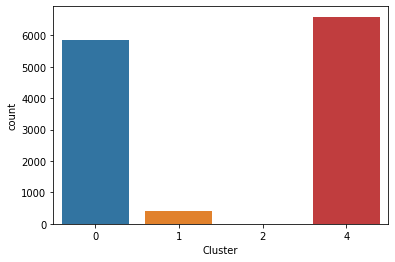

In [65]:
sns.countplot(friTrain['Cluster'])


In [66]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]


In [67]:
rushweek['Cluster'].value_counts()

4    16649
0    11660
3     3916
1      703
6      100
5       50
2        7
Name: Cluster, dtype: int64

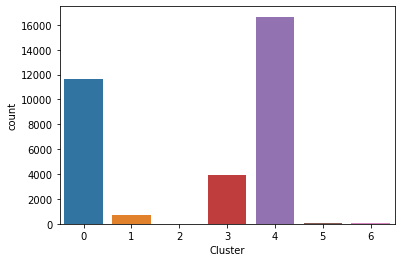

In [68]:
sns.countplot(rushweek['Cluster'])


### Let's compare the results.  Let's see the silouhette scores for each K means.

In [69]:
d1 = {'K-Cluster': ['3', '4', '5', '6', '7'],
        'Silhouette Score': [0.7885047949501834, 0.6758763880458011, 0.5042131882333108, 0.5494179299515243, 0.538226195523661]
        }

d2 = pd.DataFrame(d1)
d2

,K-Cluster,Silhouette Score
0,3,0.788505
1,4,0.675876
2,5,0.504213
3,6,0.549418
4,7,0.538226


### Seems that k = 4 was the most accurate cluster, based off silhouette score of 0.67 from K=4 to K=7.  K=3 had highest, but did not really answer our questions in terms of train delay.  

### Let's take a look at the PCA Clusters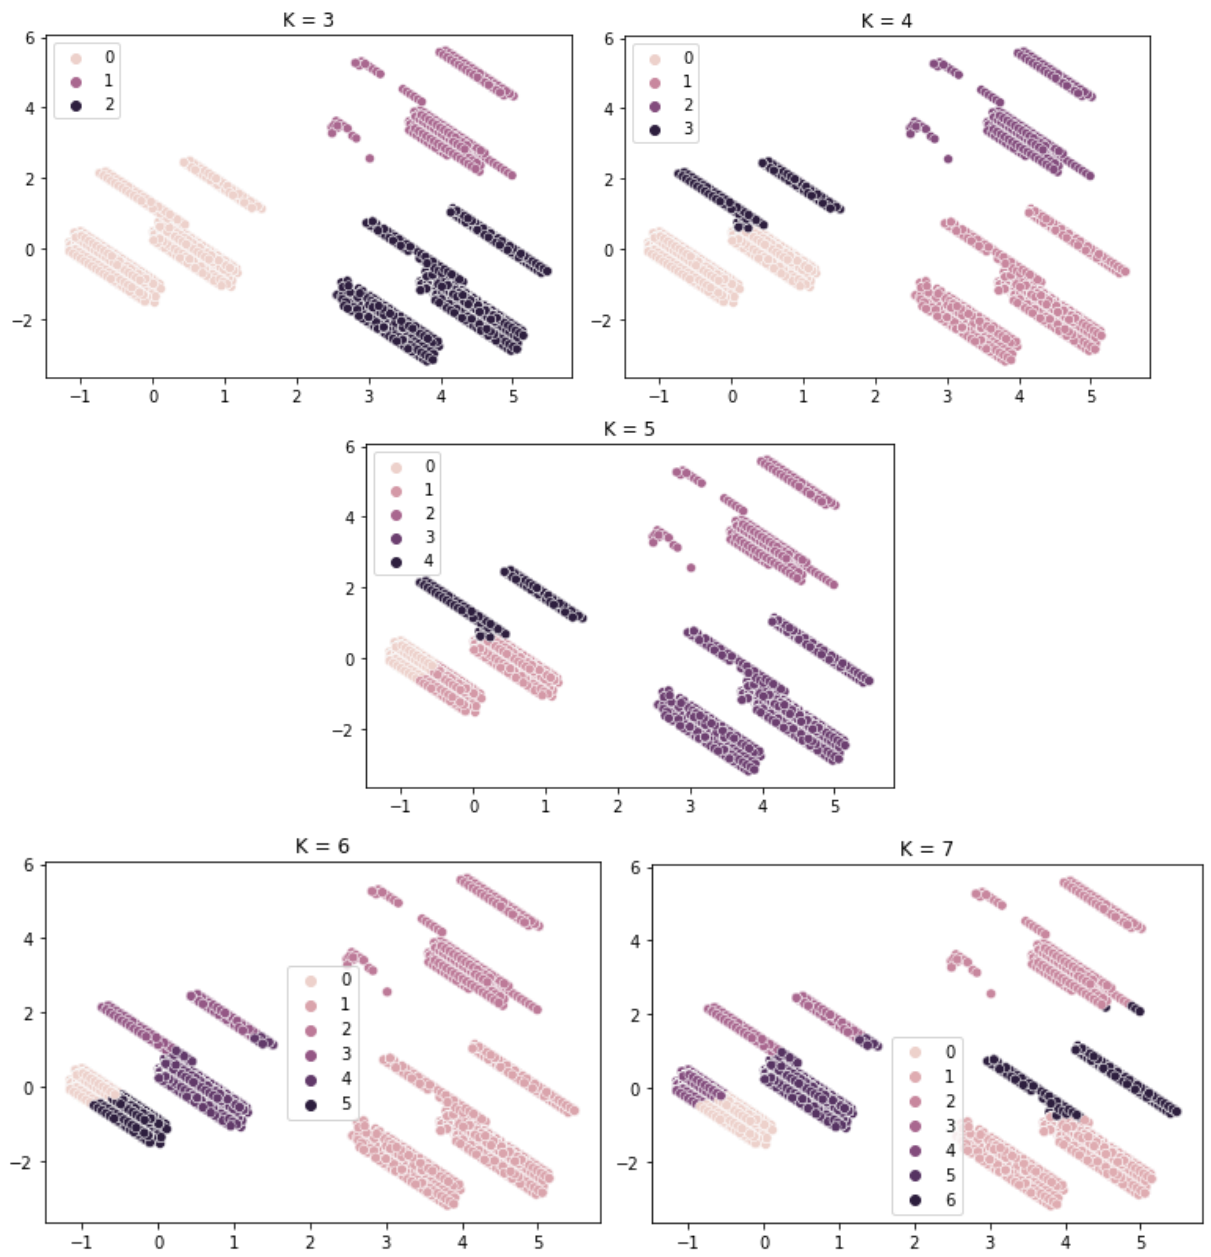

As we increase the k values, they seem to become less and less spread out.  Seems that at K = 4 is where we have the most divide, and it becomes more and more even as we increase k.

### Let's compare the results of train delay on Fridays

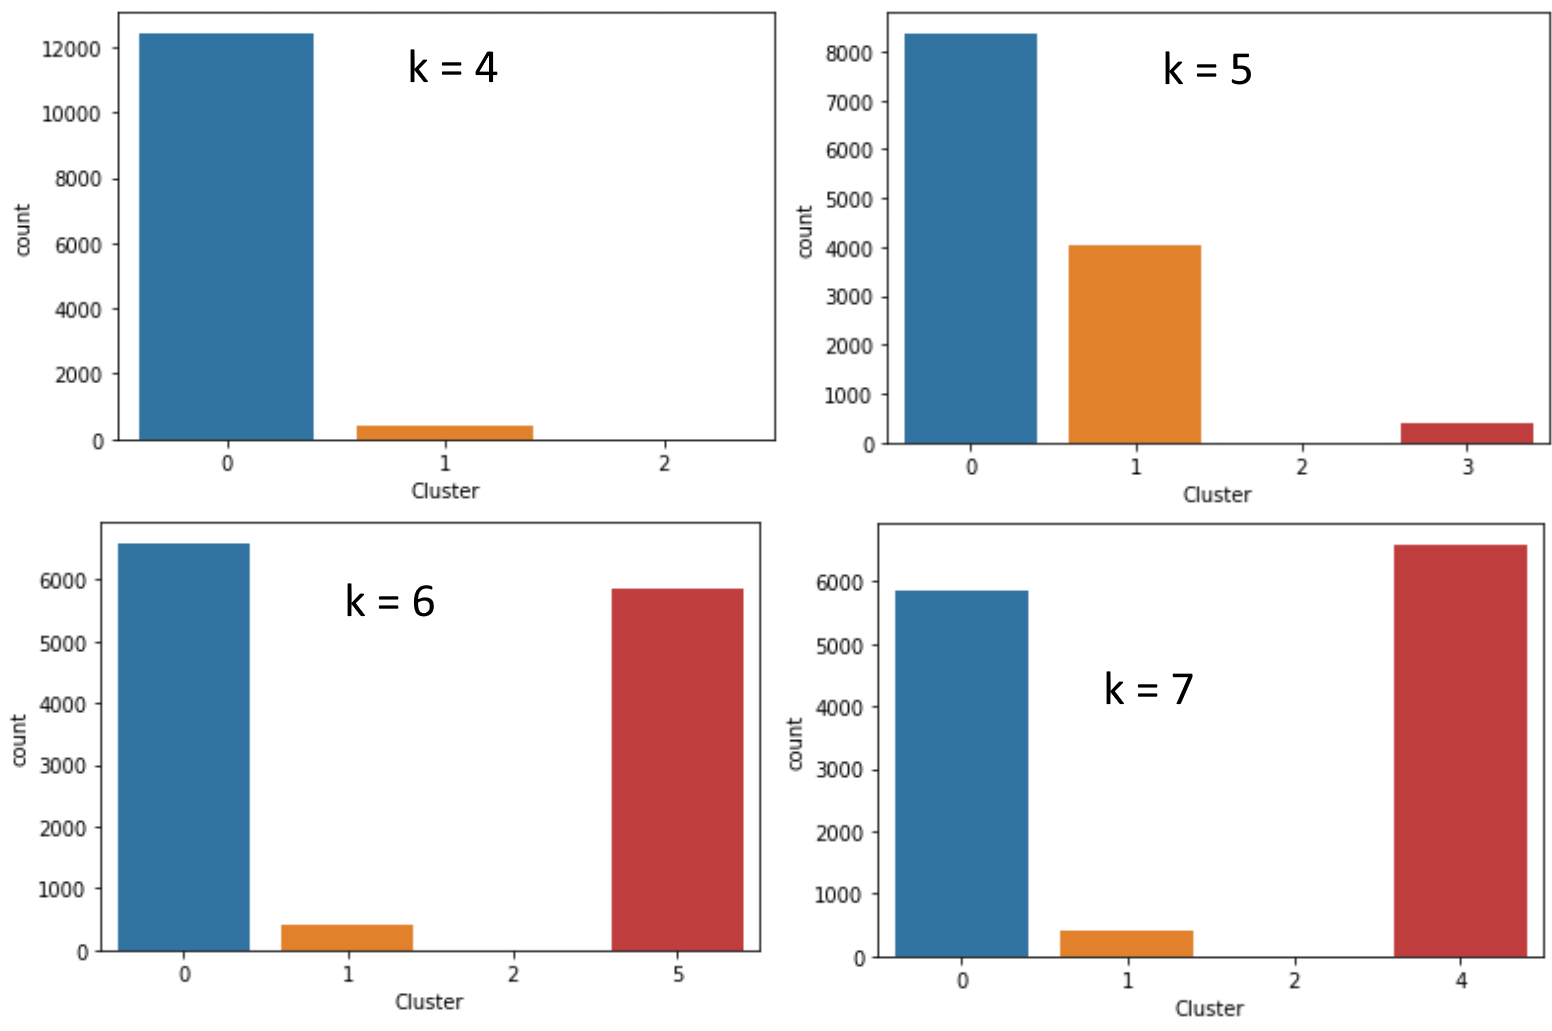

Cluster of K = 4 definetely has the most train delay during Fridays

### Let's compare the results of train delay during rushhour on weekdays

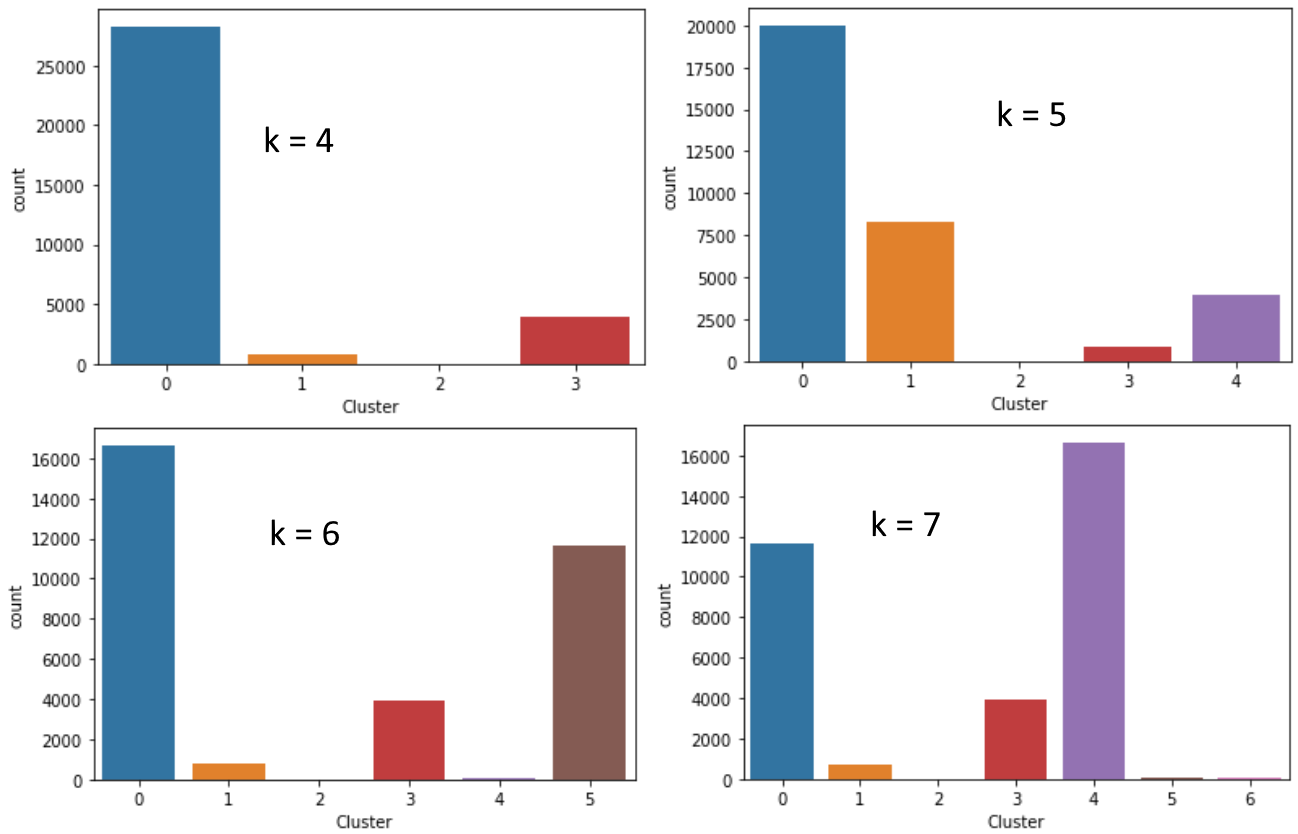

Cluster of K = 4 definetely has the most train delay during Fridays.  At K = 7, the 4th cluster has the most delays interestingly enough.  

### We will now apply T-SNE Reduction with GMM and compare the results using silouette scores and the amount of delay with clusters ranging from 3 to 7.

### T-SNE Reduction

In [70]:
Data = one_hot_encoded_data.drop(['delay_minutes'], axis = 1)
# load data into X variables
X = Data
# need to standardize the features
X_std = StandardScaler().fit_transform(X)

In [71]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 87172 samples in 12.797s...
[t-SNE] Computed neighbors for 87172 samples in 18.960s...
[t-SNE] Computed conditional probabilities for sample 1000 / 87172
[t-SNE] Computed conditional probabilities for sample 2000 / 87172
[t-SNE] Computed conditional probabilities for sample 3000 / 87172
[t-SNE] Computed conditional probabilities for sample 4000 / 87172
[t-SNE] Computed conditional probabilities for sample 5000 / 87172
[t-SNE] Computed conditional probabilities for sample 6000 / 87172
[t-SNE] Computed conditional probabilities for sample 7000 / 87172
[t-SNE] Computed conditional probabilities for sample 8000 / 87172
[t-SNE] Computed conditional probabilities for sample 9000 / 87172
[t-SNE] Computed conditional probabilities for sample 10000 / 87172
[t-SNE] Computed conditional probabilities for sample 11000 / 87172
[t-SNE] Computed conditional probabilities for sample 12000 / 87172
[t-SNE] Computed conditional probabilities for s

### GMM

### K = 3

In [72]:
from sklearn.mixture import GaussianMixture

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=3, random_state=42, max_iter=5000)

# Fit model
%timeit clusters = gmm_cluster.fit(pcadf_pca)
gmm_y_pred3 = gmm_cluster.predict(pcadf_pca)
print()
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, gmm_y_pred3, metric='euclidean')))


1 loop, best of 5: 312 ms per loop

The silhoutte score of the GMM solution: 0.7885047949506553


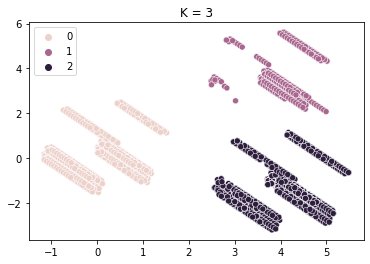

In [73]:
# Plot the solution.
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = gmm_y_pred3)
plt.title("K = 3")
plt.legend()
plt.show()

### K = 4

In [74]:
# Defining the Gaussian
gmm_cluster = GaussianMixture(n_components=4, random_state=42, max_iter=5000)

# Fit model
%timeit clusters = gmm_cluster.fit(pcadf_pca)
gmm_y_pred4 = gmm_cluster.predict(pcadf_pca)
print()
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, gmm_y_pred4, metric='euclidean')))


1 loop, best of 5: 879 ms per loop

The silhoutte score of the GMM solution: 0.6338839813035617


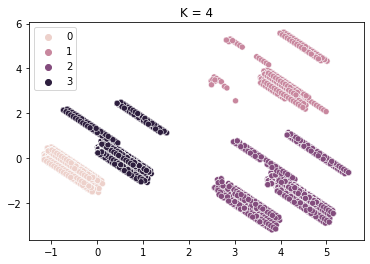

In [75]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = gmm_y_pred4)
plt.title("K = 4")
plt.legend()
plt.show()

In [76]:
one_hot_encoded_data['Cluster'] = pd.Series(gmm_y_pred4, index=one_hot_encoded_data.index)


In [77]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]

In [78]:
friTrain['Cluster'].value_counts()

0    12431
2      398
1        2
Name: Cluster, dtype: int64

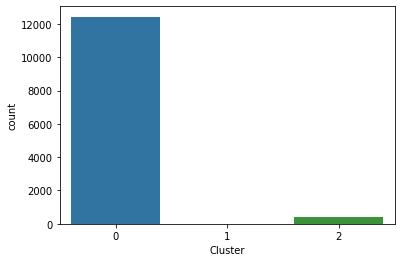

In [79]:
sns.countplot(friTrain['Cluster'])


In [80]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]


In [81]:
rushweek['Cluster'].value_counts()

0    28309
3     3966
2      803
1        7
Name: Cluster, dtype: int64

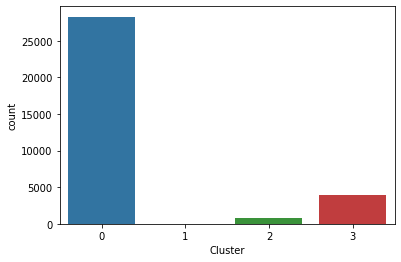

In [82]:
sns.countplot(rushweek['Cluster'])


### K = 5

In [83]:
# Defining the Gaussian
gmm_cluster = GaussianMixture(n_components=5, random_state=42, max_iter=5000)

# Fit model
%timeit clusters = gmm_cluster.fit(pcadf_pca)
gmm_y_pred5 = gmm_cluster.predict(pcadf_pca)
print()
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, gmm_y_pred5, metric='euclidean')))


1 loop, best of 5: 977 ms per loop

The silhoutte score of the GMM solution: 0.619866442495362


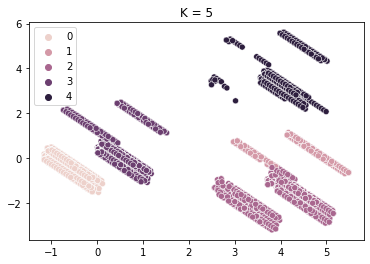

In [84]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = gmm_y_pred5)
plt.title("K = 5")
plt.legend()
plt.show()

In [85]:
one_hot_encoded_data['Cluster'] = pd.Series(gmm_y_pred5, index=one_hot_encoded_data.index)

In [86]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]


In [87]:
friTrain['Cluster'].value_counts()

0    12431
2      398
4        2
Name: Cluster, dtype: int64

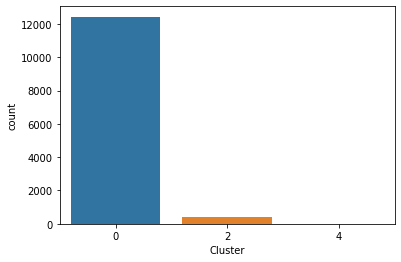

In [88]:
sns.countplot(friTrain['Cluster'])


In [89]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]


In [90]:
rushweek['Cluster'].value_counts()

0    28309
3     3966
2      717
1       86
4        7
Name: Cluster, dtype: int64

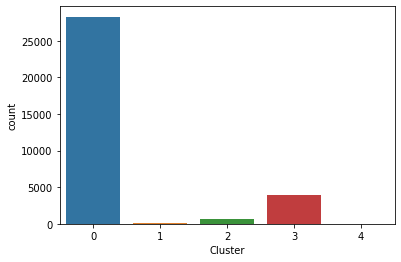

In [91]:
sns.countplot(rushweek['Cluster'])


### K = 6

In [92]:
# Defining the Gaussian
gmm_cluster = GaussianMixture(n_components=6, random_state=42, max_iter=5000)

# Fit model
%timeit clusters = gmm_cluster.fit(pcadf_pca)
gmm_y_pred6 = gmm_cluster.predict(pcadf_pca)
print()
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, gmm_y_pred6, metric='euclidean')))


1 loop, best of 5: 2.23 s per loop

The silhoutte score of the GMM solution: 0.6044758382514636


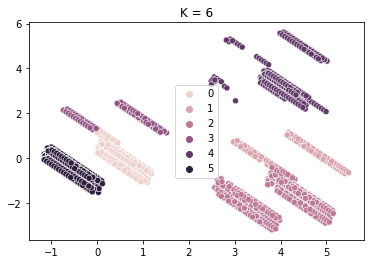

In [93]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = gmm_y_pred6)
plt.title("K = 6")
plt.legend()
plt.show()

In [94]:
one_hot_encoded_data['Cluster'] = pd.Series(gmm_y_pred6, index=one_hot_encoded_data.index)


In [95]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]



In [96]:
friTrain['Cluster'].value_counts()

5    12431
2      398
4        2
Name: Cluster, dtype: int64

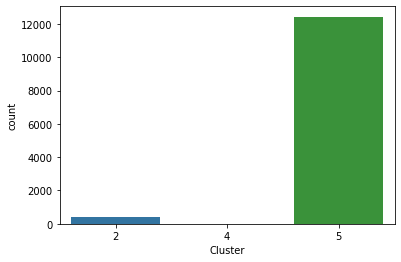

In [97]:
sns.countplot(friTrain['Cluster'])


In [98]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]



In [99]:
rushweek['Cluster'].value_counts()

5    28309
3     3503
2      717
0      463
1       86
4        7
Name: Cluster, dtype: int64

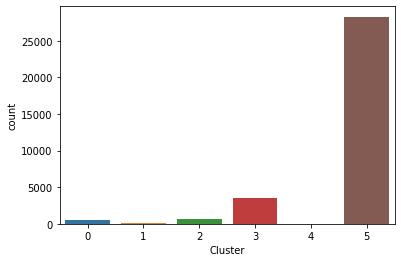

In [100]:
sns.countplot(rushweek['Cluster'])


### K = 7

In [101]:
# Defining the Gaussian
gmm_cluster = GaussianMixture(n_components=7, random_state=42, max_iter=5000)

# Fit model
%timeit clusters = gmm_cluster.fit(pcadf_pca)
gmm_y_pred7 = gmm_cluster.predict(pcadf_pca)
print()
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(pcadf_pca, gmm_y_pred7, metric='euclidean')))


1 loop, best of 5: 2.49 s per loop

The silhoutte score of the GMM solution: 0.6015783010623971


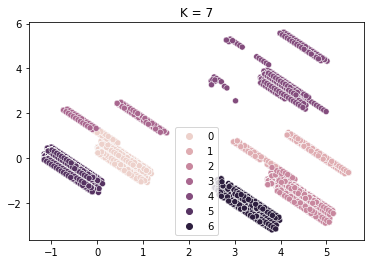

In [102]:
sns.scatterplot(pcadf_pca[:,0], pcadf_pca[:,1], hue = gmm_y_pred7)
plt.title("K = 7")
plt.legend()
plt.show()

In [103]:
one_hot_encoded_data['Cluster'] = pd.Series(gmm_y_pred7, index=one_hot_encoded_data.index)


In [104]:
friTrain = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_2', 'DayOfWeekID_3', 'DayOfWeekID_4', 'DayOfWeekID_5', 'DayOfWeekID_7'], axis=1)
friTrain = friTrain[friTrain['is_Delayed_id']== 1]
friTrain = friTrain[friTrain['DayOfWeekID_6']== 1]


In [105]:
friTrain['Cluster'].value_counts()

5    12431
6      398
4        2
Name: Cluster, dtype: int64

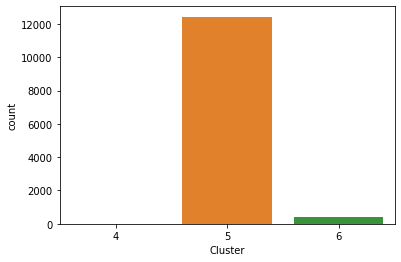

In [106]:
sns.countplot(friTrain['Cluster'])


In [107]:
rushweek = one_hot_encoded_data.drop(['DayOfWeekID_1', 'DayOfWeekID_7'], axis=1)
rushweek = rushweek[rushweek['is_Delayed_id']== 1]
rushweek = rushweek[rushweek['rush_hour']== 1]


In [108]:
rushweek['Cluster'].value_counts()

5    28309
3     3503
6      703
0      463
1       85
2       15
4        7
Name: Cluster, dtype: int64

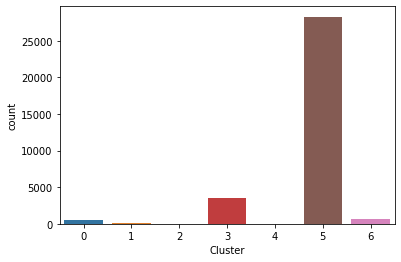

In [109]:
sns.countplot(rushweek['Cluster'])


### Let's Compare Silhouette Scores of T-SNE Reduction

In [111]:
d3 = {'N-Component': ['3', '4', '5', '6', '7'],
        'Silhouette Score': [0.7885047949506553, 0.6338839813035617, 0.619866442495362, 0.6044758382514636, 0.6015783010623971]
        }

d4 = pd.DataFrame(d3)
d4

,N-Component,Silhouette Score
0,3,0.788505
1,4,0.633884
2,5,0.619866
3,6,0.604476
4,7,0.601578


### Let's compare the TSNE Clusters

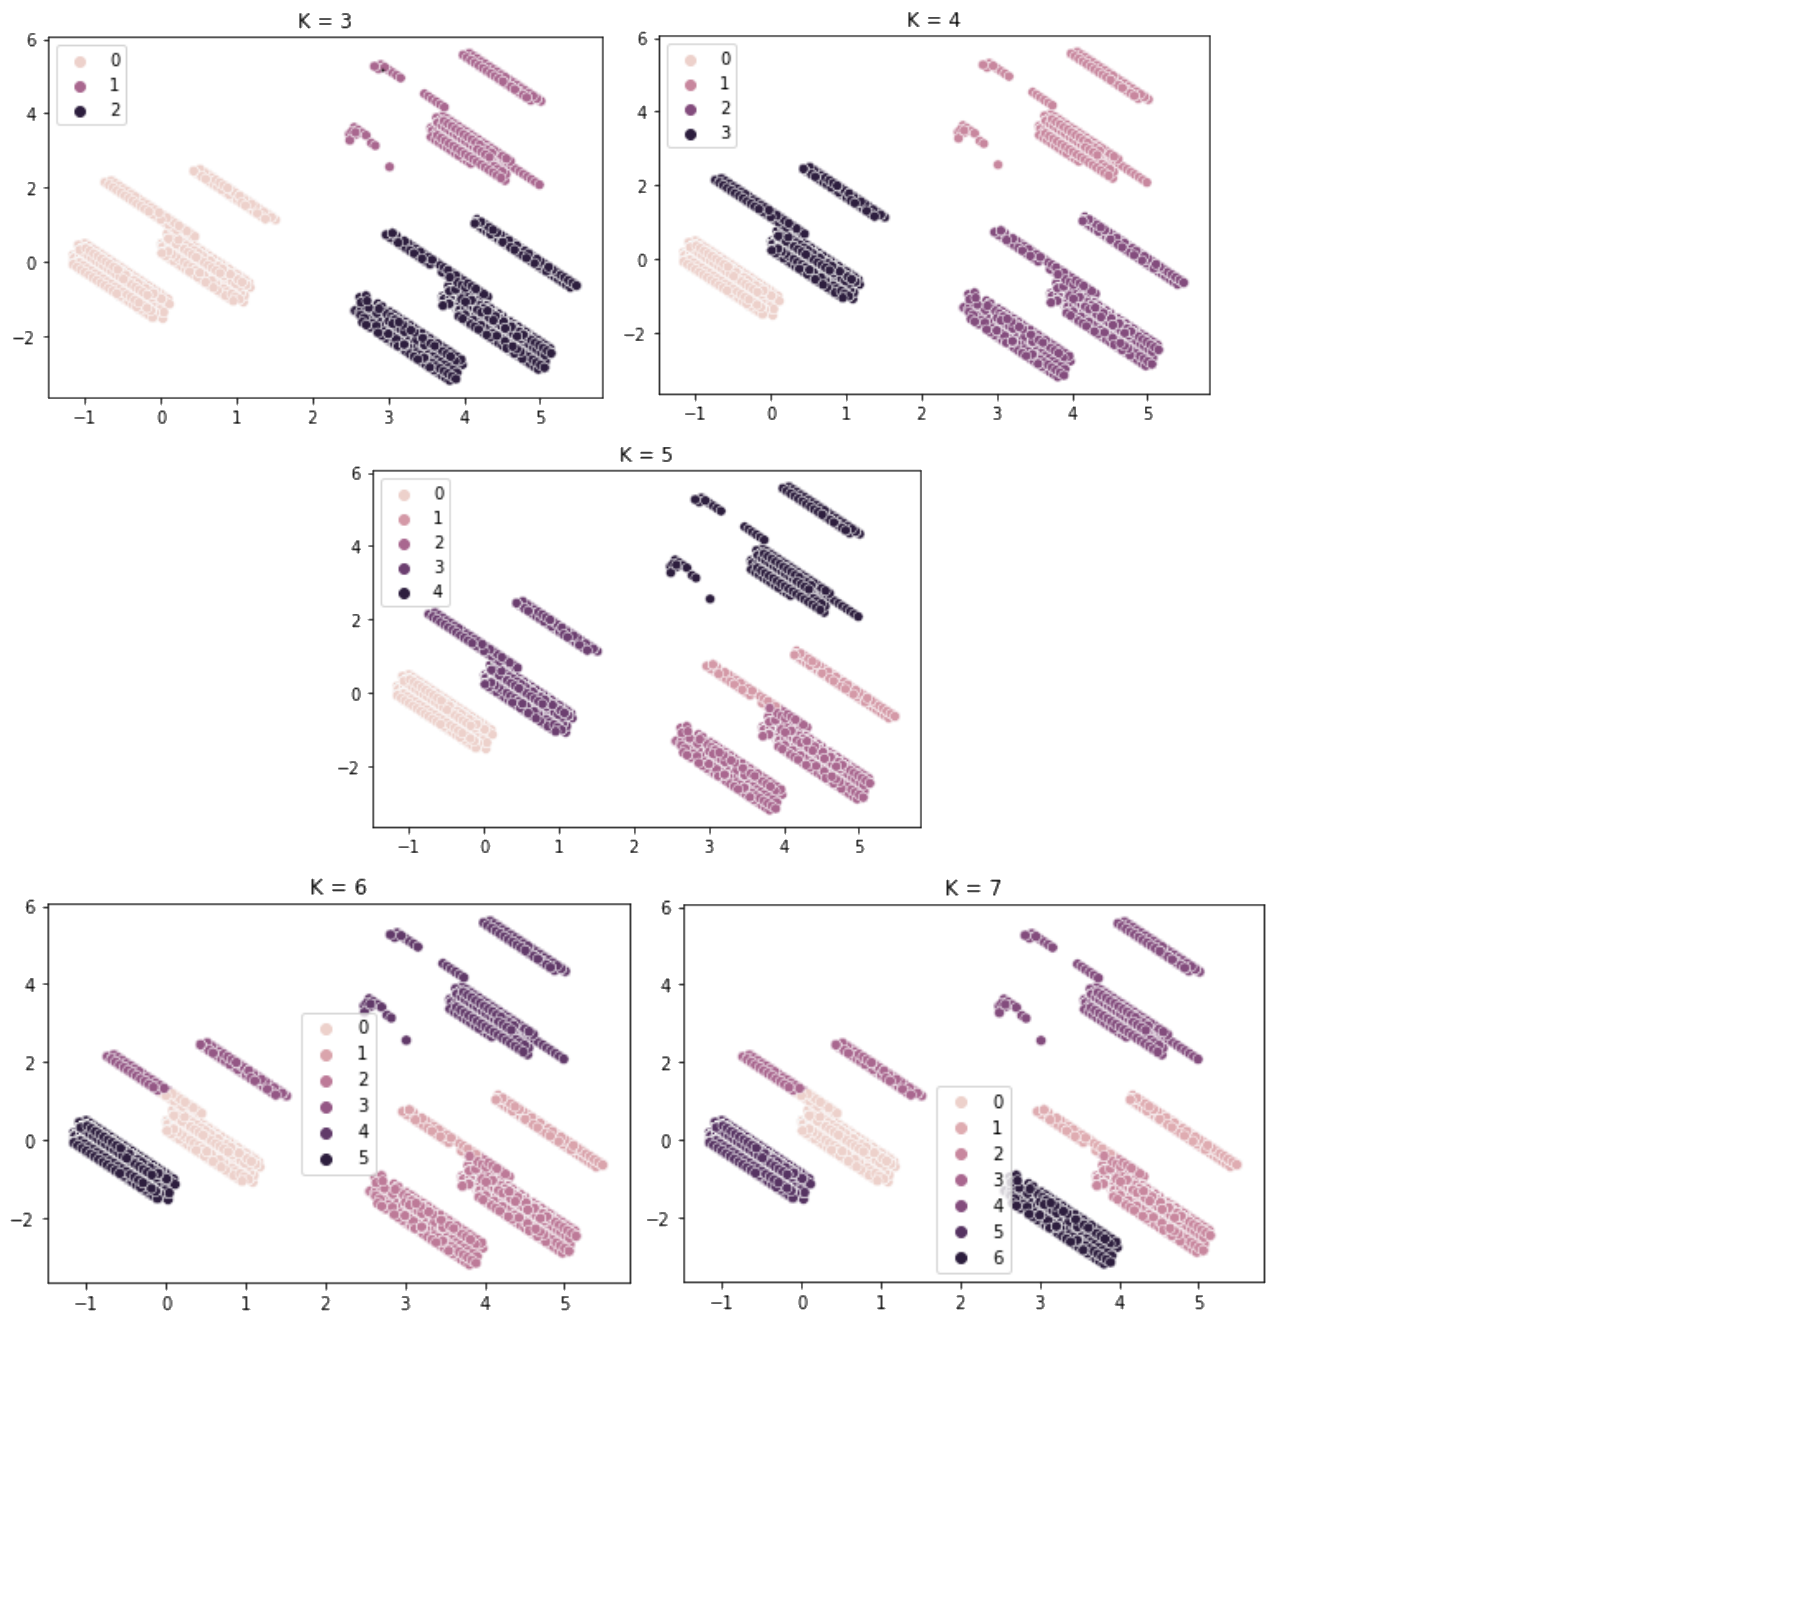


It seems that as we increase K values in Tsne, there becomes more and more of a divide with the clusters.  K = 7 seems to provide the most.

### Let's compare the tresults of train delay on Fridays
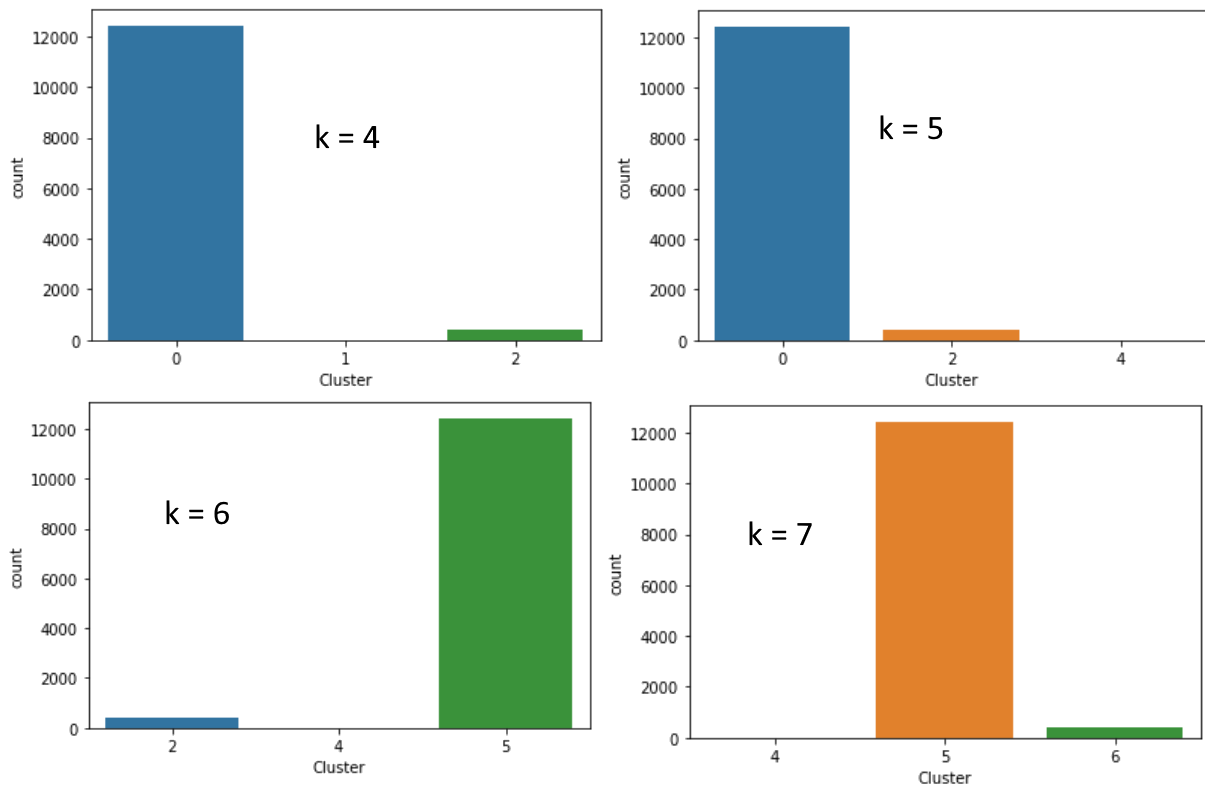

Seems that all of the Clusters have about the same amount of train delay when we increase K values.  Some form of 12,000.  There's no conclusive answer exactly to this.  

### Let's compare the results of train delay during rushhour on weekdays
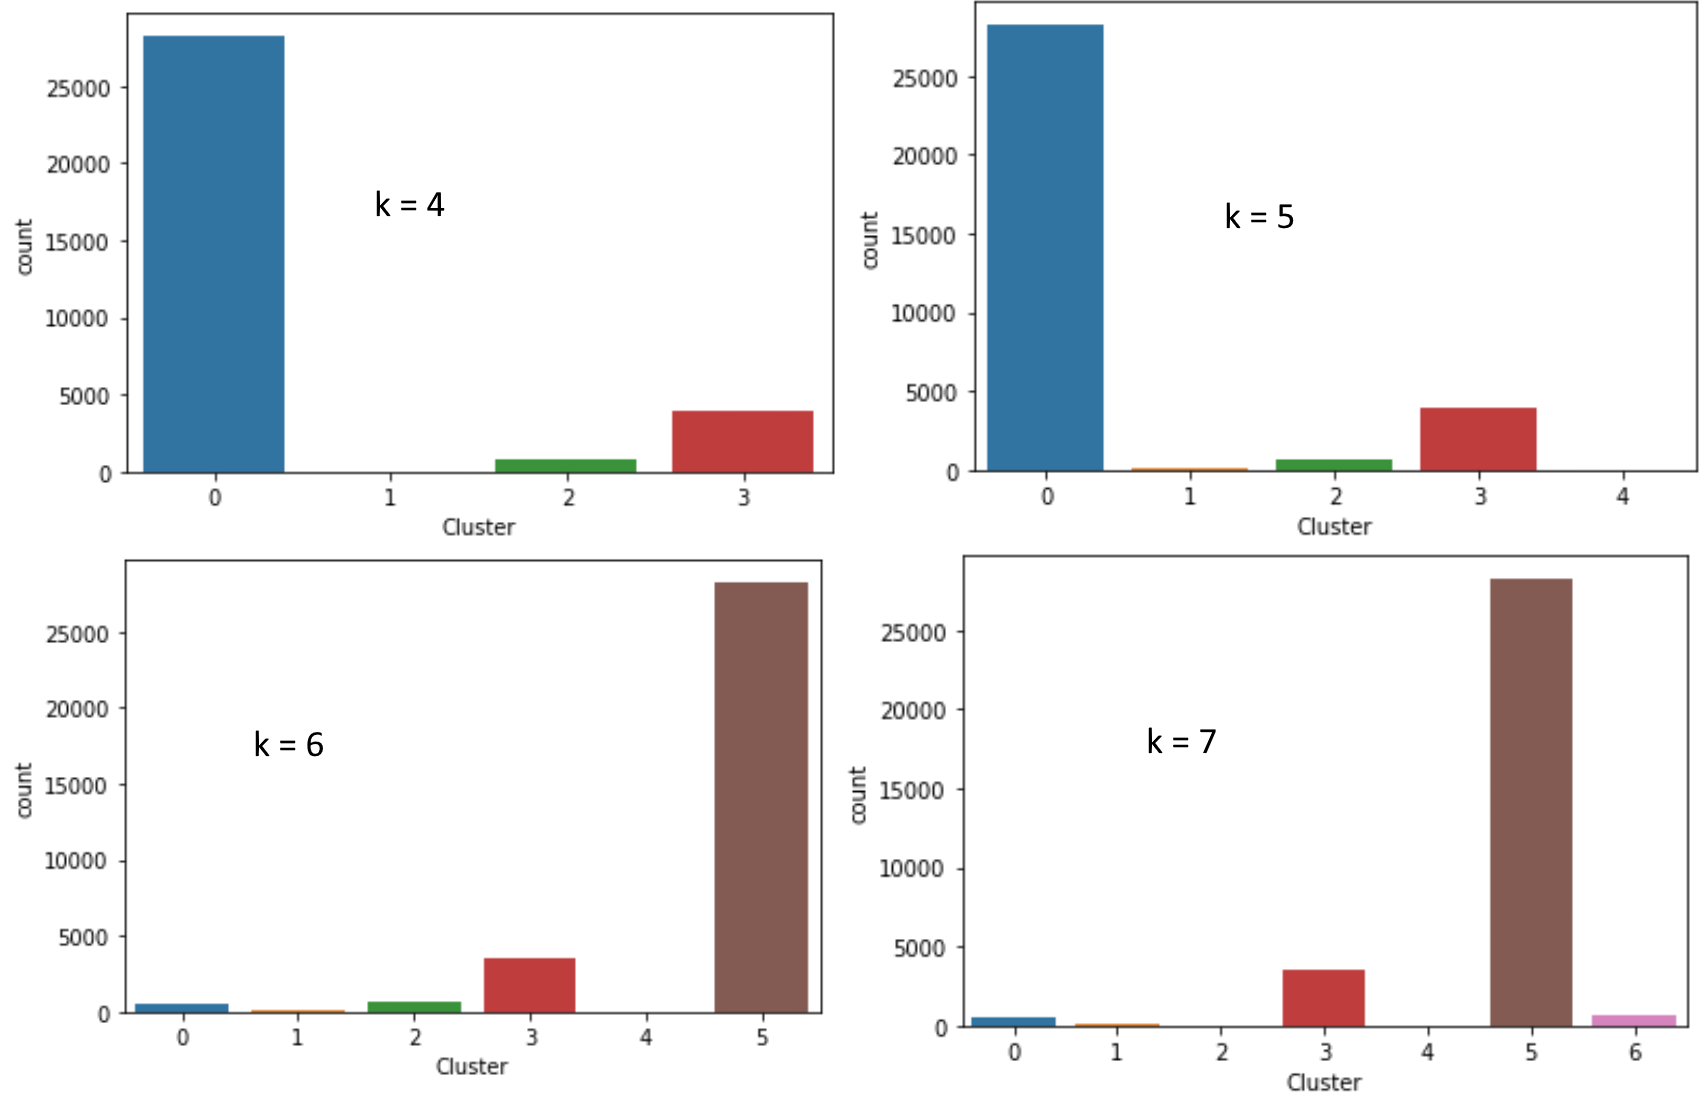

Once again, a fairly even amount of train delay as we increase.  K = 6 seems to have other clusters have more delay, so if I had to choose, K = 6 would have the most delay on rushhur on weekdays.  All of them have around 28000 worth of train delay.  

### Results:  Which Model Reduction is superior?

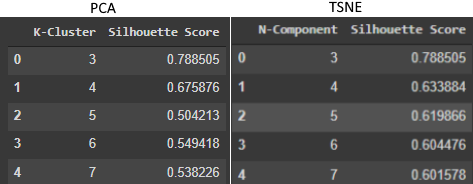

Based on silhouette_score, T-SNE Reduction definitely is more accurate than PCA, especially when we increase the number of clusters. 

One reason is that T-SNE preserves only local similarities whereas PA preserves large pairwise distance maximize variance. It takes a set of points in high dimensional data and converts it into low dimensional data

Based on the Friday and Rush Hour models, GMM also provided a better cluster than K-Means.  If we compare both algorithms, the Gaussian mixtures seem to be more robust due to being a probabalistic algorithm. By assigning the probabilities to datapoints, we can express how strong is our belief that a given datapoint belongs to a specific cluster.   

### Conclusion